In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table



save = False

sns.set(style="whitegrid")

In [2]:
# SELECTING THE FEATURES FOR CALCULATING THE ORBITS OF BANARY STARS FROM GAIA DR3
features = [
    "source_id",
    "ra",
    "dec",
    "ra_error",
    "dec_error",
    "ra_dec_corr",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
    "phot_g_mean_mag",
    "phot_bp_mean_mag",
    "phot_rp_mean_mag",
    "bp_rp",
    "radial_velocity",
    "radial_velocity_error",
    "ipd_frac_multi_peak",
    "ipd_gof_harmonic_amplitude",
    "astrometric_chi2_al",
    "astrometric_n_good_obs_al",
    "ruwe",
    "duplicated_source"
]

## Detecting Wide Binaries

In [3]:
raw_df = pd.read_csv("DATA/Pleiades_Chulkov_filtered_Gaia_DR3.csv")
print(f"Number of stars in the Pleiades: {len(raw_df)}")

# SELECTING THE FEATURES FOR CALCULATING THE ORBITS OF BANARY STARS FROM GAIA DR3
df = raw_df[features]
df.head()

Number of stars in the Pleiades: 423


,source_id,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,pmra_error,...,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source
0,65588484235454592,58.268967,22.801153,0.013425,0.008666,-0.124594,7.293433,0.014909,19.036700,0.017368,...,12.250756,1.599491,6.250218,0.944959,0,0.025033,352.88670,329,1.044438,False
1,65641913628380288,58.488726,23.345105,0.021880,0.012707,0.022201,7.415903,0.022449,20.241861,0.033256,...,12.603915,1.842890,19.819576,3.596542,0,0.037106,684.19150,363,1.425352,False
2,65660158649542784,57.908559,23.182920,0.214735,0.123755,0.108511,7.656667,0.237372,23.660945,0.275715,...,11.961829,1.690461,6.110118,2.084974,0,0.016865,113344.97000,429,13.699448,False
3,65673593307063552,57.816005,23.282072,0.018949,0.011151,-0.086201,7.391214,0.019583,20.266120,0.023781,...,13.089289,2.054302,-1.554802,4.088157,0,0.036792,482.27945,447,1.075288,False
4,65677372878285312,57.714441,23.328869,0.014915,0.008545,0.050938,7.333805,0.016010,18.888363,0.017319,...,11.491251,1.262271,6.402642,0.464261,0,0.043562,832.00635,419,1.130002,False


In [4]:
print(df['radial_velocity'].isna().sum())

51


In [5]:
## SELECTING THE STARS THAT DON'T HAVE ANY NAN VALUES
#df = df.dropna()
#df = df[(df['duplicated_source']==False) & (df['ruwe'] < 1.4)]

df.reset_index(inplace=True, drop=True)

print(f"Number of stars in the Pleiades after removing NaN values: {len(df)}")

Number of stars in the Pleiades after removing NaN values: 423


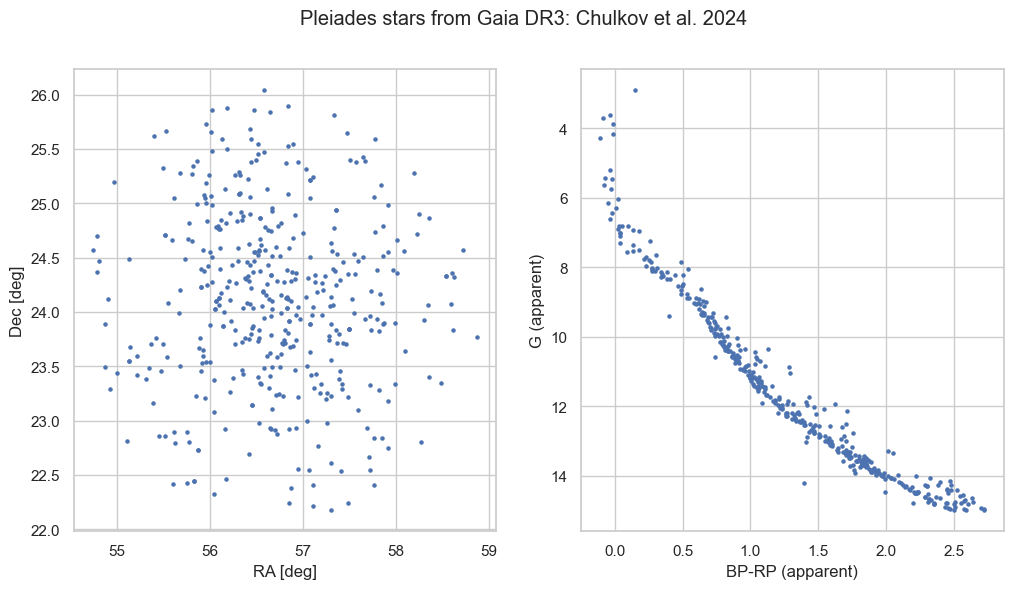

In [6]:
plotPath = "plots/"
if not os.path.exists(plotPath):
    os.makedirs(plotPath)

## Check plot:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Pleiades stars from Gaia DR3: Chulkov et al. 2024")
ax[0].scatter(df["ra"], df["dec"], s=5)
ax[0].set_xlabel("RA [deg]")
ax[0].set_ylabel("Dec [deg]")

ax[1].scatter(df["bp_rp"], df["phot_g_mean_mag"], s=5)
ax[1].set_ylabel("G (apparent)")
ax[1].set_xlabel("BP-RP (apparent)")
ax[1].invert_yaxis()

if save:
    fig.savefig(plotPath+"Pleiades_Gaia_DR3_Chulkov_et_al_2024.png", dpi=300)

### Calculating Mass 

In [7]:
## ISOCHRONE

# Read the first few lines to inspect structure
iso_data = 'DATA/output69089225567.dat'                 #output69089225567.dat is the one where a put an Av = 0.15 as the paper suggests
with open(iso_data, "r") as f:
    lines = f.readlines()

# Show the first 20 lines to understand header and column structure
lines[:20]

['# File generated by CMD 3.8 (http://stev.oapd.inaf.it/cmd) on Wed May 21 17:25:42 UTC 2025\n',
 '# isochrones based on PARSEC release v2.0 \n',
 '# Basic references: Costa et al. 2019a,2019b for the code, Nguyen et al. 2022 for the tracks.\n',
 '# Rotating tracks computed with omega_i=0.00, except for lower masses (see paper)\n',
 '# Thermal pulse cycles included \n',
 '# On RGB, assumed Reimers mass loss with efficiency eta=0.2\n',
 '# LPV periods and growth rates added cf. Trabucchi et al. (2019)\n',
 '# but fundamental-mode LPV periods + transition are from Trabucchi et al. (2021)\n',
 '# Photometric system: Gaia EDR3 (all Vegamags, Gaia passbands from ESA/Gaia website)\n',
 "# Attention: photometry includes extinction of Av=0.15, with coefficients derived star-by-star, for Cardelli et al 89 + O'Donnell 94 Rv=3.1 extinction curve.\n",
 '# Using YBC version of bolometric corrections as in Chen et al. (2019)\n',
 '# O-rich circumstellar dust ignored\n',
 '# C-rich circumstellar dust

In [8]:
# Find the header line (starts with "# Zini")
header_line_index = next(i for i, line in enumerate(lines) if line.startswith('# Zini'))

# Extract column names from the header line
column_names = lines[header_line_index].lstrip("#").strip().split()

# Read the data from the file using pandas, skipping the header lines
isochrone_df = pd.read_csv(
    iso_data,
    delim_whitespace=True,
    comment="#",
    names=column_names
)

# Select relevant CMD columns
iso_cmd_df = isochrone_df[["Mass", "G_BP_fSBmag", "G_fSBmag", "G_RP_fSBmag"]]
iso_cmd_df.head()

,Mass,G_BP_fSBmag,G_fSBmag,G_RP_fSBmag
0,0.090,16.719,13.868,12.353
1,0.096,16.593,13.740,12.225
2,0.100,16.475,13.645,12.135
3,0.106,16.289,13.509,12.007
4,0.114,15.915,13.262,11.783


C:\Users\bosca\AppData\Local\Temp\ipykernel_676\2856367970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["BP-RP fSBmag"] = iso_cmd_df["G_BP_fSBmag"].values - iso_cmd_df["G_RP_fSBmag"].values


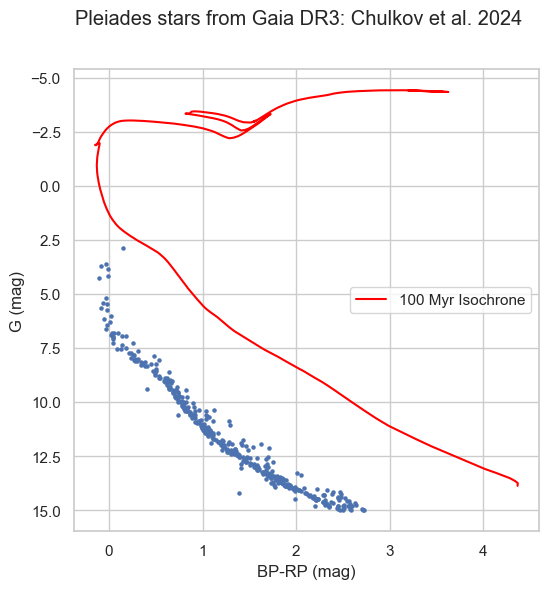

In [9]:
## plot against the data:

iso_cmd_df["BP-RP fSBmag"] = iso_cmd_df["G_BP_fSBmag"].values - iso_cmd_df["G_RP_fSBmag"].values
color_iso = iso_cmd_df["BP-RP fSBmag"].values
mag_iso = iso_cmd_df["G_fSBmag"]

fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Pleiades stars from Gaia DR3: Chulkov et al. 2024")

ax.scatter(df["bp_rp"], df["phot_g_mean_mag"], s=5)
ax.plot(color_iso, mag_iso, color='red', label='100 Myr Isochrone')
ax.set_ylabel("G (mag)")
ax.set_xlabel("BP-RP (mag)")
ax.invert_yaxis()
ax.legend(loc='center right')

In [10]:
# Extinction in Gaia bands (using Casagrande+ 2021, typical for AV = 0.15):

mu = 5.65                   # distance modulus for 135 pc
A_V = 0.15                  # extinction in V band
A_G = 0.789 * A_V           # extinction in G band
A_BP = 1.067 * A_V          # extinction in BP band
A_RP = 0.634 * A_V          # extinction in RP band

# Correct the magnitudes
iso_cmd_df["CORR G_fSBmag"] = iso_cmd_df["G_fSBmag"] + mu + A_G
iso_cmd_df["CORR G_BP_fSBmag"] = iso_cmd_df["G_BP_fSBmag"] + mu + A_BP
iso_cmd_df["CORR G_RP_fSBmag"] = iso_cmd_df["G_RP_fSBmag"] + mu + A_RP
iso_cmd_df['CORR BP-RP fSBmag'] = iso_cmd_df["CORR G_BP_fSBmag"].values - iso_cmd_df["CORR G_RP_fSBmag"].values

# isochrone cuts for pleiades stars

iso_pleiades = iso_cmd_df[
    (iso_cmd_df["CORR G_fSBmag"] < 16.0) &
    (iso_cmd_df["CORR G_fSBmag"] > 3.8) &
    (iso_cmd_df["CORR BP-RP fSBmag"] < 5.0) &
    (iso_cmd_df["CORR BP-RP fSBmag"] > - 0.5)
].copy()


C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3644795417.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["CORR G_fSBmag"] = iso_cmd_df["G_fSBmag"] + mu + A_G
C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3644795417.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["CORR G_BP_fSBmag"] = iso_cmd_df["G_BP_fSBmag"] + mu + A_BP
C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3644795417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

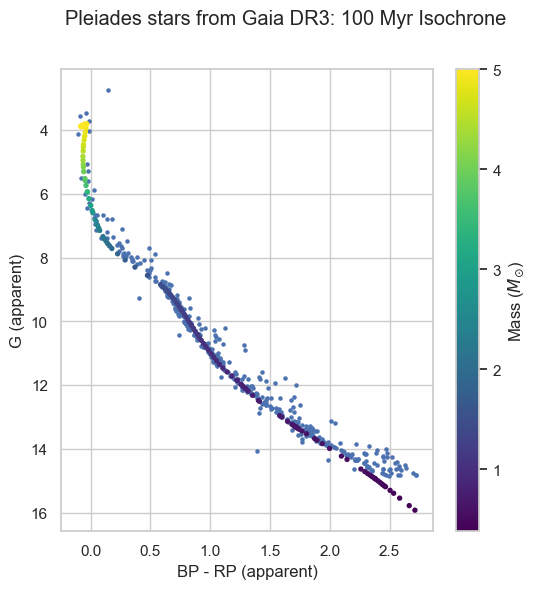

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Pleiades stars from Gaia DR3: 100 Myr Isochrone")

ax.scatter(df['bp_rp'], df["phot_g_mean_mag"] - 0.15, s=5)
sc = ax.scatter(iso_pleiades['CORR BP-RP fSBmag'], iso_pleiades["CORR G_fSBmag"].values, c=iso_pleiades["Mass"], cmap='viridis', s=8, label='Isochrone (100 Myr)')
ax.set_xlabel("BP - RP (apparent)")
ax.set_ylabel("G (apparent)")
ax.invert_yaxis()
legend = ax.legend(loc='upper right')
legend.remove()  # Remove legend for scatter, as colorbar is more informative

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"Mass ($M_{\odot}$)")

if save:
    fig.savefig(plotPath+"Pleiades_Gaia_DR3_Chulkov_et_al_2024_isochrone.png", dpi=300)

In [12]:
## good, now we assigne the mass from the isochrone for each stars in Gaia dataframe

def assign_mass(row, iso_df):
    # Find the closest mass in the isochrone data
    closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
    return closest_mass

df['Mass (M_sun)'] = df.apply(lambda row: assign_mass(row, iso_pleiades), axis=1)
print(f"Number of stars in the Pleiades with radial velocity and mass: {len(df)}")

C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3240133964.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3240133964.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3240133964.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort

Number of stars in the Pleiades with radial velocity and mass: 423


C:\Users\bosca\AppData\Local\Temp\ipykernel_676\3240133964.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mass (M_sun)'] = df.apply(lambda row: assign_mass(row, iso_pleiades), axis=1)


In [13]:
df.head(20)

,source_id,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,pmra_error,...,bp_rp,radial_velocity,radial_velocity_error,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source,Mass (M_sun)
0,65588484235454592,58.268967,22.801153,0.013425,0.008666,-0.124594,7.293433,0.014909,19.036700,0.017368,...,1.599491,6.250218,0.944959,0,0.025033,352.88670,329,1.044438,False,0.695
1,65641913628380288,58.488726,23.345105,0.021880,0.012707,0.022201,7.415903,0.022449,20.241861,0.033256,...,1.842890,19.819576,3.596542,0,0.037106,684.19150,363,1.425352,False,0.600
2,65660158649542784,57.908559,23.182920,0.214735,0.123755,0.108511,7.656667,0.237372,23.660945,0.275715,...,1.690461,6.110118,2.084974,0,0.016865,113344.97000,429,13.699448,False,0.661
3,65673593307063552,57.816005,23.282072,0.018949,0.011151,-0.086201,7.391214,0.019583,20.266120,0.023781,...,2.054302,-1.554802,4.088157,0,0.036792,482.27945,447,1.075288,False,0.557
4,65677372878285312,57.714441,23.328869,0.014915,0.008545,0.050938,7.333805,0.016010,18.888363,0.017319,...,1.262271,6.402642,0.464261,0,0.043562,832.00635,419,1.130002,False,0.816
5,65680499614460800,57.989008,23.339221,0.014527,0.008449,0.101453,7.484240,0.014865,20.844311,0.018879,...,1.465252,5.429410,1.014421,0,0.024680,648.59180,418,1.072775,False,0.747
6,65690498298435840,58.353538,23.403957,0.047446,0.027588,-0.011887,7.539437,0.049088,20.973390,0.072212,...,2.325146,0.197040,4.820275,0,0.017866,2971.08720,338,3.085630,False,0.513
7,65712488530853120,58.093865,23.644663,0.016725,0.008423,-0.028021,7.842320,0.016345,20.351204,0.022248,...,1.828077,8.562927,2.124587,0,0.081661,390.80020,380,1.052246,False,0.614
8,65750627840192256,58.870949,23.772242,0.014308,0.008699,0.007505,7.250917,0.015259,17.759083,0.018394,...,1.735012,0.921870,2.339711,0,0.027942,462.76154,394,1.120992,False,0.634
9,65800930496992512,58.616589,23.835175,0.013759,0.008399,-0.044843,7.622050,0.014964,19.623070,0.017765,...,1.699927,2.231457,8.190568,0,0.021413,555.91156,357,1.091179,False,0.661


In [14]:
if save:
    df.to_csv("DATA/My_Pleiades_filtered_Gaia_DR3_with_mass.csv", index=False)

In [15]:
print(df['radial_velocity'].isna().sum())
print(df['parallax'].isna().sum())

51
16


## From Resolving Pleiades Binary paper

Here where simulate the same method of the Section 5

### Step 1: Find Close Gaia Pairs

- Use a search radius ≤ 10 arcsec.

- For each source, check if there's a Gaia neighbor within that radius.

### Step 2: For Each Pair:
Extract proper motions of both stars.

Compute: Relative proper motion (δµ) and Parallax difference (∆ϖ/σ)

If δµ < 10 mas/yr and ∆ϖ/σ is small → likely a physical binary.

In [16]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from itertools import combinations

def angular_separation(ra1, dec1, ra2, dec2):
    c1 = SkyCoord(ra1*u.deg, dec1*u.deg)
    c2 = SkyCoord(ra2*u.deg, dec2*u.deg)
    return c1.separation(c2).arcsec


def compute_binary_params(s1, s2):    
    delta_pmra = s1['pmra'] - s2['pmra']
    delta_pmdec = s1['pmdec'] - s2['pmdec']
    delta_mu = np.sqrt(delta_pmra**2 + delta_pmdec**2)

    delta_parallax = abs(s1['parallax'] - s2['parallax'])
    sigma_parallax = np.sqrt(s1['parallax_error']**2. + s2['parallax_error']**2.) 
    delta_parallax_sigma = delta_parallax / sigma_parallax

    return delta_mu, delta_parallax_sigma

# Step 1: Find candidate pairs within 10 arcsec
pairs = []
for (i1, star1), (i2, star2) in combinations(df.iterrows(), 2):
    sep = angular_separation(star1['ra'], star1['dec'], star2['ra'], star2['dec'])

    if sep <= 10:
        delta_mu, delta_parallax_sigma = compute_binary_params(star1, star2)

        if star1['Mass (M_sun)'] > star2['Mass (M_sun)']:
            q = star1['Mass (M_sun)'] / star2['Mass (M_sun)']
        else:
            q = star2['Mass (M_sun)'] / star1['Mass (M_sun)']

        pairs.append({
            'primary_id': star1['source_id'],
            'secondary_id': star2['source_id'],
            'sep_arcsec': sep,
            'delta_mu': delta_mu,
            'delta_parallax_sigma': delta_parallax_sigma,
            'primary_mass': star1['Mass (M_sun)'],
            'secondary_mass': star2['Mass (M_sun)'],
            'mass ration (q)': star1['Mass (M_sun)'] / star2['Mass (M_sun)'],
        })

pairs_df = pd.DataFrame(pairs)

In [17]:
print(pairs_df.shape)
pairs_df.head(20)

(20, 8)


,primary_id,secondary_id,sep_arcsec,delta_mu,delta_parallax_sigma,primary_mass,secondary_mass,mass ration (q)
0,64814045795106944,64814050089186048,0.543919,NaN,NaN,0.836,0.834,1.002398
1,64837139834697984,64837242912474624,1.709579,1.943963,0.806509,1.220,1.453,0.839642
2,66507469798631808,66507469798631936,3.284751,3.483568,0.547493,2.472,5.001,0.494301
3,66507469798631936,66507469798632320,6.828030,4.595541,1.135834,5.001,1.067,4.686973
4,68364544933829376,68364544935515392,1.339814,1.416886,1.625398,0.600,0.614,0.977199
5,66584332530000512,66584332532300288,1.055689,NaN,NaN,0.770,5.001,0.153969
6,64956123313498368,64956127609464320,3.609500,1.503277,0.354115,5.001,2.801,1.785434
7,66733552578791296,66733556873061120,0.887718,6.046547,1.217122,0.750,5.001,0.149970
8,65207709611941376,65207709613871744,6.274134,2.241359,0.557441,2.600,1.163,2.235598
9,65212691773969280,65212691775922048,1.267525,0.594925,0.652204,5.001,0.600,8.335000


In [18]:
## For this study we're interested in stars with delta_mu < 10 mas/yr and delta_parallax_sigma < 3
pairs_df_filtered = pairs_df.dropna()
pairs_df_filtered.reset_index(drop=True, inplace=True)
pairs_df_filtered.head(20)

,primary_id,secondary_id,sep_arcsec,delta_mu,delta_parallax_sigma,primary_mass,secondary_mass,mass ration (q)
0,64837139834697984,64837242912474624,1.709579,1.943963,0.806509,1.220,1.453,0.839642
1,66507469798631808,66507469798631936,3.284751,3.483568,0.547493,2.472,5.001,0.494301
2,66507469798631936,66507469798632320,6.828030,4.595541,1.135834,5.001,1.067,4.686973
3,68364544933829376,68364544935515392,1.339814,1.416886,1.625398,0.600,0.614,0.977199
4,64956123313498368,64956127609464320,3.609500,1.503277,0.354115,5.001,2.801,1.785434
5,66733552578791296,66733556873061120,0.887718,6.046547,1.217122,0.750,5.001,0.149970
6,65207709611941376,65207709613871744,6.274134,2.241359,0.557441,2.600,1.163,2.235598
7,65212691773969280,65212691775922048,1.267525,0.594925,0.652204,5.001,0.600,8.335000
8,66798496781121792,66798526845337344,8.839234,0.926880,0.572119,3.397,0.625,5.435200
9,65230764996027776,65230764998207232,1.057715,6.377004,0.068317,1.568,1.663,0.942874


In [19]:
# Dividing into two dataframes: one with pairs from Chulkov et al. 2024 and one with the rest
primary_members_df = df[df['source_id'].isin(pairs_df_filtered['primary_id'])].copy()
secondary_members_df = df[df['source_id'].isin(pairs_df_filtered['secondary_id'])].copy()



# Step 1: Create an empty list to store the filtered rows
filtered_gaia_rows = []

# Step 2: Iterate over each Primary_Gaia_source_id and get the corresponding Gaia row
for primary_id in pairs_df_filtered['primary_id']:
    # Find the corresponding row in Gaia data for the given source_id
    row = primary_members_df[primary_members_df['source_id'] == primary_id]
    
    # Append the row to the filtered list
    filtered_gaia_rows.append(row)

# Step 3: Concatenate all the filtered rows back into a DataFrame
primary_members_df_sorted = pd.concat(filtered_gaia_rows, ignore_index=True)

# same for secondary members:
filtered_gaia_rows = []

for secondary_id in pairs_df_filtered['secondary_id']:
    row = secondary_members_df[secondary_members_df['source_id'] == secondary_id]
    filtered_gaia_rows.append(row)

secondary_members_df_sorted = pd.concat(filtered_gaia_rows, ignore_index=True)



primary_members_df_sorted.reset_index(inplace=True, drop=True)
secondary_members_df_sorted.reset_index(inplace=True, drop=True)

print(primary_members_df_sorted.shape)
print(secondary_members_df_sorted.shape)

(15, 25)
(15, 25)


Now let's visualize the dataframe of both member with the orbital feature that we need

In [20]:
orbital_features = ['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Mass (M_sun)', 'bp_rp', 'phot_g_mean_mag', 'ra_error', 'dec_error', 'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error']

primary_members_df_orbits = primary_members_df_sorted[orbital_features]
secondary_members_df_orbits = secondary_members_df_sorted[orbital_features]

primary_members_df_orbits.head(20)

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),bp_rp,phot_g_mean_mag,ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error
0,64837139834697984,55.871670,22.734388,21.901688,-45.302615,7.556975,3.375552,1.220,0.777434,9.766249,0.021143,0.014818,0.027257,0.018957,0.020694,1.553394
1,66507469798631808,57.491988,23.848487,18.377840,-45.870328,7.389021,NaN,2.472,0.055337,6.806421,0.035412,0.019844,0.045998,0.025840,0.038254,NaN
2,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,4.707757,5.001,NaN,10.005213,0.033703,0.018977,0.038665,0.025343,0.033577,0.533899
3,68364544933829376,55.515926,24.712536,21.721589,-45.292485,7.485806,12.204306,0.600,1.873280,13.592579,0.042979,0.035992,0.067268,0.057571,0.057112,4.892858
4,64956123313498368,56.453032,23.147851,19.029377,-45.463108,7.404870,5.299024,5.001,NaN,10.126517,0.018650,0.011918,0.024697,0.014803,0.018652,0.219587
5,66733552578791296,56.655542,24.343339,22.380244,-45.516188,7.410337,6.865205,0.750,1.393290,12.441148,0.063617,0.040097,0.108746,0.062642,0.060509,3.227011
6,65207709611941376,56.851821,23.914478,20.049108,-44.132590,7.220987,-1.856786,2.600,0.042299,7.286501,0.030519,0.022987,0.041599,0.029272,0.034383,2.441681
7,65212691773969280,56.825476,24.036436,21.437427,-44.729549,7.272170,NaN,5.001,NaN,14.673646,0.091097,0.086623,0.133004,0.119678,0.070745,NaN
8,66798496781121792,56.477085,24.554305,20.331403,-46.022055,7.305275,11.792832,3.397,-0.022990,5.752026,0.072686,0.047801,0.094875,0.062754,0.083877,0.599952
9,65230764996027776,56.566777,24.189728,19.605545,-43.759370,7.399227,NaN,1.568,0.444091,8.228746,0.030415,0.021397,0.039749,0.027052,0.032742,NaN


In [21]:
secondary_members_df_orbits.head(20)

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),bp_rp,phot_g_mean_mag,ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error
0,64837242912474624,55.872124,22.734611,20.073610,-45.963769,7.532519,NaN,1.453,0.595700,8.885260,0.019930,0.015486,0.027618,0.019842,0.022165,NaN
1,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,4.707757,5.001,NaN,10.005213,0.033703,0.018977,0.038665,0.025343,0.033577,0.533899
2,66507469798632320,57.489468,23.846882,21.530787,-43.565036,7.642781,0.934193,1.067,0.906862,10.234675,0.245120,0.135241,0.280003,0.176236,0.245663,2.455118
3,68364544935515392,55.516250,24.712309,22.205939,-46.624015,7.815114,4.740833,0.614,1.799292,13.516845,0.164402,0.149010,0.227048,0.174573,0.194385,7.600933
4,64956127609464320,56.453495,23.146943,20.513910,-45.699760,7.421140,7.813674,2.801,0.024569,6.895188,0.039314,0.026078,0.052866,0.033643,0.041989,1.356579
5,66733556873061120,56.655274,24.343309,16.380963,-44.761626,7.289905,4.082545,5.001,NaN,12.744133,0.080105,0.053588,0.155214,0.090544,0.078291,1.769425
6,65207709613871744,56.849928,23.914271,19.605919,-46.329695,7.185576,5.368229,1.163,0.832858,9.739319,0.046900,0.036556,0.060045,0.044302,0.053416,0.577683
7,65212691775922048,56.825778,24.036218,22.032321,-44.735675,7.340276,-15.318983,0.600,1.863250,13.563175,0.076396,0.063868,0.090451,0.076116,0.076810,4.030274
8,66798526845337344,56.479764,24.554604,19.533205,-45.550902,7.355189,4.299448,0.625,1.765072,13.832768,0.023091,0.014974,0.032283,0.019225,0.024003,5.253680
9,65230764998207232,56.566787,24.189435,20.755874,-50.031764,7.395438,17.248915,1.663,0.403328,9.408872,0.038971,0.025160,0.048889,0.033384,0.044757,22.786419


In [22]:
primary_non_nan_indicses = np.where(primary_members_df_orbits['radial_velocity'].notna())[0]
secondary_non_nan_indicses = np.where(secondary_members_df_orbits['radial_velocity'].notna())[0]

print("Primary members with radial velocity:", primary_non_nan_indicses)
print("Secondary members with radial velocity:", secondary_non_nan_indicses)

# finding the common indices of primary and secondary members
common_indices = np.intersect1d(primary_non_nan_indicses, secondary_non_nan_indicses)

print("Common indices with radial velocity:", common_indices)

Primary members with radial velocity: [ 0  2  3  4  5  6  8 10 11 12 13 14]
Secondary members with radial velocity: [ 1  2  3  4  5  6  7  8  9 10 11 13 14]
Common indices with radial velocity: [ 2  3  4  5  6  8 10 11 13 14]


In [23]:
primary_members_df_filtered = primary_members_df_orbits.iloc[common_indices].copy()
secondary_members_df_filtered = secondary_members_df_orbits.iloc[common_indices].copy()

primary_members_df_filtered.to_csv("DATA/My_primary_members_binary_Pleiades_filtered.csv", index=False)
secondary_members_df_filtered.to_csv("DATA/My_secondary_members_binary_Pleiades_filtered.csv", index=False)

In [24]:
from matplotlib import cm

# Generate 20 well-separated colors from the 'viridis' colormap
num_colors = len(primary_members_df_filtered)
colors = [cm.tab20(i / num_colors) for i in range(num_colors)]

# Example usage: print the colors
print(colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


C:\Users\bosca\AppData\Local\Temp\ipykernel_676\441357656.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter([primary_members_df_filtered.iloc[i]['ra'], secondary_members_df_filtered.iloc[i]['ra']],
C:\Users\bosca\AppData\Local\Temp\ipykernel_676\441357656.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter([primary_members_df_filtered.iloc[i]['bp_rp'], secondary_members_df_filtered.iloc[i]['bp_

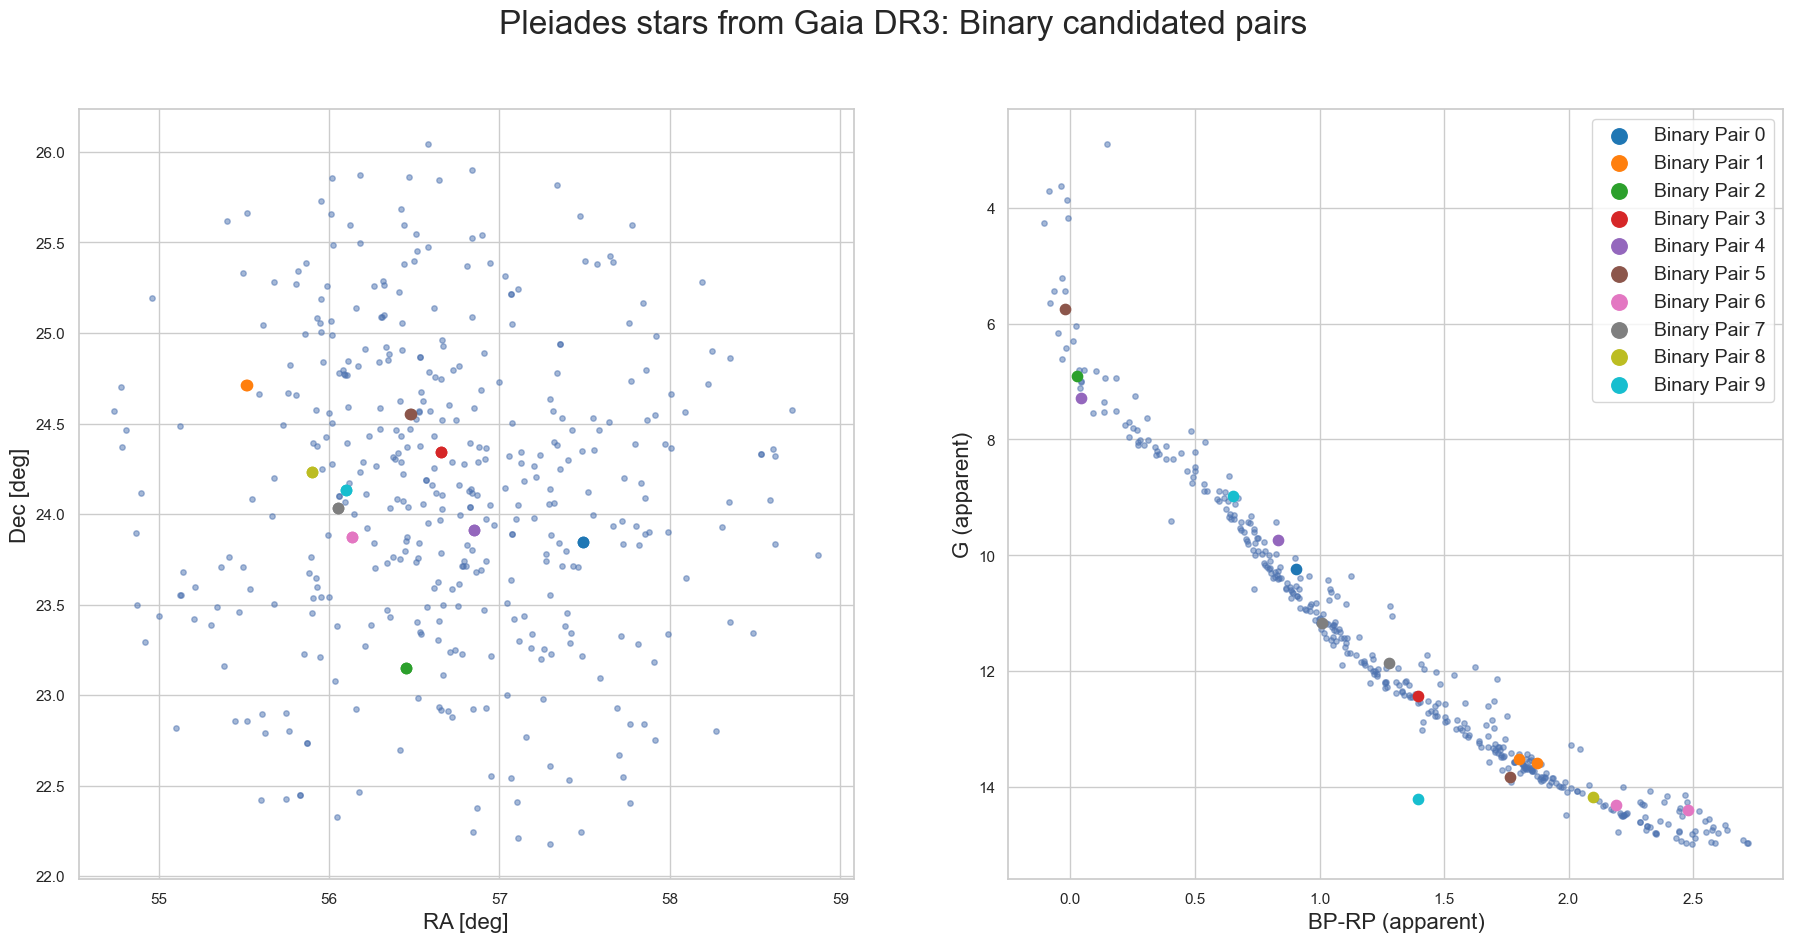

In [26]:
## Check plot:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle("Pleiades stars from Gaia DR3: Binary candidated pairs", fontsize=24)
ax[0].scatter(df["ra"], df["dec"], s=15, alpha=0.5)
for i in range(len(primary_members_df_filtered)):
    ax[0].scatter([primary_members_df_filtered.iloc[i]['ra'], secondary_members_df_filtered.iloc[i]['ra']],
                  [primary_members_df_filtered.iloc[i]['dec'], secondary_members_df_filtered.iloc[i]['dec']],
                  alpha=1.0, s=55, label=f'Binary Pair {i}', c=colors[i])
ax[0].set_xlabel("RA [deg]", fontsize=16)
ax[0].set_ylabel("Dec [deg]", fontsize=16)

ax[1].scatter(df["bp_rp"], df["phot_g_mean_mag"], s=15, alpha=0.5)
for i in range(len(primary_members_df_filtered)):
    ax[1].scatter([primary_members_df_filtered.iloc[i]['bp_rp'], secondary_members_df_filtered.iloc[i]['bp_rp']],
                  [primary_members_df_filtered.iloc[i]['phot_g_mean_mag'], secondary_members_df_filtered.iloc[i]['phot_g_mean_mag']],
                  alpha=1.0, s=55, label=f'Binary Pair {i}', c=colors[i])
ax[1].set_ylabel("G (apparent)", fontsize=16)
ax[1].set_xlabel("BP-RP (apparent)", fontsize=16)
ax[1].invert_yaxis()
ax[1].legend(loc='upper right', fontsize=14, markerscale=1.5)

if save:
    fig.savefig(plotPath+"My_Pleiades_binary_pairs_Gaia_DR3.png", dpi=300)

Now for calculate the orbitals of the binaries we need al the astronometric information as radial velocity and parallax.
let's filter our pairs catalogues

## retrive Radial velocity

In [27]:
from astropy.table import Table


RV_data = Table.read('DATA/radial_velocity_single_lined_objects.fit').to_pandas()
ID_list = Table.read('DATA/list_analyzed_object_radial_velocities.fit').to_pandas()
RV_data_double = Table.read('DATA/radial_velocities_double_lined_objects.fit').to_pandas()

print(RV_data.shape)
print(ID_list.shape)
ID_list.head(20)

(4631, 8)
(377, 11)


,Seq,Name,RA_ICRS,DE_ICRS,Gaia,Gmag,plx,e_plx,pmRA,e_pmRA,recno
0,1,b'AK III-31',51.88537,25.89995,117280133627745280,9.05,13.737,0.021,16.513,0.023,1
1,2,b'PELS 121',51.92529,23.80351,68711956249760768,10.13,5.237,0.015,4.479,0.016,2
2,3,b'PELS 1',52.06861,22.64106,61842035801405824,10.41,2.281,0.049,15.006,0.050,3
3,4,b'AK III-59',52.16877,25.60767,69221506874062720,11.51,6.334,0.020,24.659,0.025,4
4,5,b'AK III-79',52.35599,25.65215,69595035885590144,9.33,7.318,0.017,31.053,0.019,5
5,6,b'AK III-158',52.80562,26.43951,69659730977217792,9.12,10.624,0.021,15.011,0.025,6
6,7,b'AK III-153',52.81658,25.25526,69335619861034752,8.09,7.617,0.033,22.625,0.037,7
7,8,b'AK III-170',52.89021,26.26528,69643757994608512,10.58,6.923,0.018,20.649,0.018,8
8,9,b'AK II-131',53.27437,22.13405,61554650949438208,11.21,7.558,0.019,22.183,0.025,9
9,10,b'AK II-138',53.30801,23.00623,67680850564641792,11.69,7.941,0.014,22.730,0.016,10


In [28]:
RV_data.head(20)

,Seq,Name,HJD,RVel,e_RVel,S_N,Inst,recno
0,2,b'PELS 121',52497.8622,5.670000,0.50,11,1,1
1,2,b'PELS 121',52529.8427,6.320000,0.75,11,1,2
2,2,b'PELS 121',52583.7015,5.590000,0.52,10,1,3
3,2,b'PELS 121',56672.6857,5.600000,0.09,54,2,4
4,2,b'PELS 121',56977.8214,5.600000,0.13,40,2,5
5,2,b'PELS 121',56978.7596,5.550000,0.09,52,2,6
6,2,b'PELS 121',56986.6941,5.630000,0.10,47,2,7
7,2,b'PELS 121',56987.7665,5.620000,0.11,44,2,8
8,2,b'PELS 121',56988.7337,5.540000,0.10,47,2,9
9,2,b'PELS 121',57359.7191,5.550000,0.09,50,2,10


In [29]:
def get_star_name(df, ID):

    match_source = ID[ID['Gaia'].isin(df['source_id'])].copy()

    interesting_columns = ['Gaia', 'Name']
    match_source = match_source[interesting_columns]

    return match_source

In [30]:
primary_members_names = get_star_name(primary_members_df_filtered, ID_list)
secondary_members_names = get_star_name(secondary_members_df_filtered, ID_list)

print(primary_members_names.shape)
print(secondary_members_names.shape)
print(primary_members_names.head(20))
print(secondary_members_names.head(20))

(5, 2)
(6, 2)
                  Gaia         Name
103  65247704349267584   b'HII 299'
171  66798496781121792   b'HII 817'
202  66733552578791296  b'HII 1100'
234  65207709611941376  b'HII 1397'
297  66507469798631936  b'HII 2503'
                  Gaia         Name
55   68364544935515392    b'HCG 65'
102  65248460263511552   b'HII 298'
112  65272821318002560   b'HII 338'
166  64956127609464320   b'HII 801'
233  65207709613871744  b'HII 1392'
296  66507469798632320  b'HII 2500'


In [41]:
## check the radial velocity data for primary and secondary members
for i in range(len(primary_members_names)):
    print(primary_members_names.iloc[i,1])
    print(RV_data[RV_data['Name'] == primary_members_names.iloc[i,1]].head(20))
    print('')

for i in range(len(secondary_members_names)):
    print(secondary_members_names.iloc[i,1])
    print(RV_data[RV_data['Name'] == secondary_members_names.iloc[i,1]].head(20))
    print('')

b'HII 299'
      Seq        Name         HJD  RVel  e_RVel  S_N  Inst  recno
1460  104  b'HII 299'  52927.9702  4.76    0.58   12     1   1461
1461  104  b'HII 299'  55145.9063  5.48    0.76   11     2   1462
1462  104  b'HII 299'  55853.9463  5.27    0.14   41     2   1463
1463  104  b'HII 299'  55883.8829  5.17    0.17   38     2   1464
1464  104  b'HII 299'  56257.6784  5.04    0.22   25     2   1465
1465  104  b'HII 299'  56932.9642  5.06    0.15   47     2   1466
1466  104  b'HII 299'  57288.9635  4.99    0.18   48     2   1467
1467  104  b'HII 299'  57289.9956  5.14    0.17   44     2   1468
1468  104  b'HII 299'  57291.8810  5.18    0.15   53     2   1469
1469  104  b'HII 299'  57318.8118  5.21    0.16   50     2   1470
1470  104  b'HII 299'  57319.9419  5.12    0.18   42     2   1471
1471  104  b'HII 299'  58123.6146  5.37    0.15   35     2   1472
1472  104  b'HII 299'  58154.7196  5.23    0.15   39     2   1473
1473  104  b'HII 299'  58477.6568  5.26    0.17   37     2   1474

In [29]:
primary_members_df_orbits = primary_members_df_orbits.merge(primary_members_names, left_on='source_id', right_on='Gaia', how='left')
primary_members_df_orbits.drop(columns=['Gaia'], inplace=True)  # Drop the redundant 'Gaia' column

secondary_members_df_orbits = secondary_members_df_orbits.merge(secondary_members_names, left_on='source_id', right_on='Gaia', how='left')
secondary_members_df_orbits.drop(columns=['Gaia'], inplace=True)  # Drop the redundant 'Gaia' column

primary_members_df_orbits.head()

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,Name
0,64837139834697984,55.871670,22.734388,21.901688,-45.302615,7.556975,3.375552,1.220,0.021143,0.014818,0.027257,0.018957,0.020694,1.553394,b'TRU S45'
1,66507469798631808,57.491988,23.848487,18.377840,-45.870328,7.389021,NaN,2.472,0.035412,0.019844,0.045998,0.025840,0.038254,NaN,b'HII 2507'
2,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,4.707757,5.001,0.033703,0.018977,0.038665,0.025343,0.033577,0.533899,b'HII 2503'
3,68364544933829376,55.515926,24.712536,21.721589,-45.292485,7.485806,12.204306,0.600,0.042979,0.035992,0.067268,0.057571,0.057112,4.892858,NaN
4,64956123313498368,56.453032,23.147851,19.029377,-45.463108,7.404870,5.299024,5.001,0.018650,0.011918,0.024697,0.014803,0.018652,0.219587,NaN


In [ ]:
def match_radial_velocity(df_orbits, rv_data):
    for index, row in df_orbits.iterrows():

        # Extract the Name the row
        name = row['Name']

        # find all the rv_values in rv_data:
        rv_temp = rv_data[rv_data['Name'] == name].copy()

        # extracting the RV values in the same epoch of Gaia DR3 2457394.5 JD
        if not rv_temp.empty:
            # Calculate the weighted mean of radial velocities
            
            
            df_orbits.at[index, 'radial_velocity'] = radial_velocity_info[0]
            df_orbits.at[index, 'radial_velocity_error'] = radial_velocity_info[1]
        else:
            print(f"No radial velocity data found for {name}.")
    
    return df_orbits

            


In [48]:
from astropy.time import Time

# Example: Convert Gaia's JD (for January 1st, 2016) to HJD
gaia_jd = 2457394.5  # JD for January 1st, 2016

# Convert JD to Time object
time = Time(gaia_jd, format='jd')

# Calculate Heliocentric Julian Date (HJD) from JD
hjd = time.utc  # Get the heliocentric Julian Date (HJD)
print(f"HJD: {hjd.jd}")

HJD: 2457394.5


In [39]:
primary_members_df_orbits_radial_updated = primary_members_df_orbits.copy()
secondary_members_df_orbits_radial_updated = secondary_members_df_orbits.copy()

primary_members_df_orbits_radial_updated = match_radial_velocity(primary_members_df_orbits_radial_updated, RV_data)
secondary_members_df_orbits_radial_updated = match_radial_velocity(secondary_members_df_orbits_radial_updated, RV_data)

Radial velocity for b'TRU S45': 5.371304512023926 ± 0.45338808482783155
No radial velocity data found for b'HII 2507'.
Radial velocity for b'HII 2503': 5.196112155914307 ± 0.050590840332552615
No radial velocity data found for nan.
No radial velocity data found for nan.
Radial velocity for b'HII 1100': 5.5163445472717285 ± 0.12038442881517412
Radial velocity for b'HII 1397': 6.930237293243408 ± 0.05268014318051261
No radial velocity data found for nan.
No radial velocity data found for b'HII 817'.
Radial velocity for b'HII 956': 4.150784969329834 ± 0.653224609260508
No radial velocity data found for nan.
Radial velocity for b'HII 299': 5.181736946105957 ± 0.04668818667469614
Radial velocity for b'HII 303': 5.786448955535889 ± 0.06732624579062647
No radial velocity data found for nan.
No radial velocity data found for nan.
No radial velocity data found for nan.
Radial velocity for b'HII 2503': 5.196112155914307 ± 0.050590840332552615
Radial velocity for b'HII 2500': 5.347354412078857 ± 

In [40]:
primary_members_df_orbits_radial_updated.head(20)

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,Name
0,64837139834697984,55.871670,22.734388,21.901688,-45.302615,7.556975,5.371305,1.220,0.021143,0.014818,0.027257,0.018957,0.020694,0.453388,b'TRU S45'
1,66507469798631808,57.491988,23.848487,18.377840,-45.870328,7.389021,NaN,2.472,0.035412,0.019844,0.045998,0.025840,0.038254,NaN,b'HII 2507'
2,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,5.196112,5.001,0.033703,0.018977,0.038665,0.025343,0.033577,0.050591,b'HII 2503'
3,68364544933829376,55.515926,24.712536,21.721589,-45.292485,7.485806,12.204306,0.600,0.042979,0.035992,0.067268,0.057571,0.057112,4.892858,NaN
4,64956123313498368,56.453032,23.147851,19.029377,-45.463108,7.404870,5.299024,5.001,0.018650,0.011918,0.024697,0.014803,0.018652,0.219587,NaN
5,66733552578791296,56.655542,24.343339,22.380244,-45.516188,7.410337,5.516345,0.750,0.063617,0.040097,0.108746,0.062642,0.060509,0.120384,b'HII 1100'
6,65207709611941376,56.851821,23.914478,20.049108,-44.132590,7.220987,6.930237,2.600,0.030519,0.022987,0.041599,0.029272,0.034383,0.052680,b'HII 1397'
7,65212691773969280,56.825476,24.036436,21.437427,-44.729549,7.272170,NaN,5.001,0.091097,0.086623,0.133004,0.119678,0.070745,NaN,NaN
8,66798496781121792,56.477085,24.554305,20.331403,-46.022055,7.305275,11.792832,3.397,0.072686,0.047801,0.094875,0.062754,0.083877,0.599952,b'HII 817'
9,65230764996027776,56.566777,24.189728,19.605545,-43.759370,7.399227,4.150785,1.568,0.030415,0.021397,0.039749,0.027052,0.032742,0.653225,b'HII 956'


In [41]:
secondary_members_df_orbits_radial_updated.head(20)

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,Name
0,64837242912474624,55.872124,22.734611,20.073610,-45.963769,7.532519,NaN,1.453,0.019930,0.015486,0.027618,0.019842,0.022165,NaN,NaN
1,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,5.196112,5.001,0.033703,0.018977,0.038665,0.025343,0.033577,0.050591,b'HII 2503'
2,66507469798632320,57.489468,23.846882,21.530787,-43.565036,7.642781,5.347354,1.067,0.245120,0.135241,0.280003,0.176236,0.245663,0.087532,b'HII 2500'
3,68364544935515392,55.516250,24.712309,22.205939,-46.624015,7.815114,5.766209,0.614,0.164402,0.149010,0.227048,0.174573,0.194385,0.207578,b'HCG 65'
4,64956127609464320,56.453495,23.146943,20.513910,-45.699760,7.421140,7.813674,2.801,0.039314,0.026078,0.052866,0.033643,0.041989,1.356579,b'HII 801'
5,66733556873061120,56.655274,24.343309,16.380963,-44.761626,7.289905,4.082545,5.001,0.080105,0.053588,0.155214,0.090544,0.078291,1.769425,NaN
6,65207709613871744,56.849928,23.914271,19.605919,-46.329695,7.185576,5.368229,1.163,0.046900,0.036556,0.060045,0.044302,0.053416,0.577683,b'HII 1392'
7,65212691775922048,56.825778,24.036218,22.032321,-44.735675,7.340276,7.260000,0.600,0.076396,0.063868,0.090451,0.076116,0.076810,0.900000,b'HII 1355'
8,66798526845337344,56.479764,24.554604,19.533205,-45.550902,7.355189,4.299448,0.625,0.023091,0.014974,0.032283,0.019225,0.024003,5.253680,NaN
9,65230764998207232,56.566787,24.189435,20.755874,-50.031764,7.395438,17.248915,1.663,0.038971,0.025160,0.048889,0.033384,0.044757,22.786419,NaN


In [45]:
# mask of Nan values
mask_na = [0,1,7]

# Filter rows based on index values
primary_members_df_orbits_radial_updated = primary_members_df_orbits_radial_updated.loc[primary_members_df_orbits_radial_updated.index.difference(mask_na)]
secondary_members_df_orbits_radial_updated = secondary_members_df_orbits_radial_updated.loc[secondary_members_df_orbits_radial_updated.index.difference(mask_na)]

# Display the first 20 rows of the updated dataframe
primary_members_df_orbits_radial_updated.head(20)

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,Name
2,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,5.196112,5.001,0.033703,0.018977,0.038665,0.025343,0.033577,0.050591,b'HII 2503'
3,68364544933829376,55.515926,24.712536,21.721589,-45.292485,7.485806,12.204306,0.600,0.042979,0.035992,0.067268,0.057571,0.057112,4.892858,NaN
4,64956123313498368,56.453032,23.147851,19.029377,-45.463108,7.404870,5.299024,5.001,0.018650,0.011918,0.024697,0.014803,0.018652,0.219587,NaN
5,66733552578791296,56.655542,24.343339,22.380244,-45.516188,7.410337,5.516345,0.750,0.063617,0.040097,0.108746,0.062642,0.060509,0.120384,b'HII 1100'
6,65207709611941376,56.851821,23.914478,20.049108,-44.132590,7.220987,6.930237,2.600,0.030519,0.022987,0.041599,0.029272,0.034383,0.052680,b'HII 1397'
8,66798496781121792,56.477085,24.554305,20.331403,-46.022055,7.305275,11.792832,3.397,0.072686,0.047801,0.094875,0.062754,0.083877,0.599952,b'HII 817'
9,65230764996027776,56.566777,24.189728,19.605545,-43.759370,7.399227,4.150785,1.568,0.030415,0.021397,0.039749,0.027052,0.032742,0.653225,b'HII 956'
10,65241313435901568,56.133429,23.874849,19.578880,-45.423405,7.367450,15.866132,0.549,0.035543,0.026848,0.047870,0.036978,0.039420,14.526879,NaN
11,65247704349267584,56.054523,24.030616,21.404856,-45.886219,7.594804,5.181737,0.971,0.017696,0.012250,0.022041,0.015386,0.019992,0.046688,b'HII 299'
12,65249250535404928,56.061059,24.101915,20.708631,-43.436798,7.137587,5.786449,0.809,0.015210,0.011326,0.019034,0.014365,0.017789,0.067326,b'HII 303'


In [46]:
primary_members_df_orbits_radial_updated.head(20)

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,Mass (M_sun),ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,Name
2,66507469798631936,57.491184,23.847947,21.026666,-48.132843,7.361154,5.196112,5.001,0.033703,0.018977,0.038665,0.025343,0.033577,0.050591,b'HII 2503'
3,68364544933829376,55.515926,24.712536,21.721589,-45.292485,7.485806,12.204306,0.600,0.042979,0.035992,0.067268,0.057571,0.057112,4.892858,NaN
4,64956123313498368,56.453032,23.147851,19.029377,-45.463108,7.404870,5.299024,5.001,0.018650,0.011918,0.024697,0.014803,0.018652,0.219587,NaN
5,66733552578791296,56.655542,24.343339,22.380244,-45.516188,7.410337,5.516345,0.750,0.063617,0.040097,0.108746,0.062642,0.060509,0.120384,b'HII 1100'
6,65207709611941376,56.851821,23.914478,20.049108,-44.132590,7.220987,6.930237,2.600,0.030519,0.022987,0.041599,0.029272,0.034383,0.052680,b'HII 1397'
8,66798496781121792,56.477085,24.554305,20.331403,-46.022055,7.305275,11.792832,3.397,0.072686,0.047801,0.094875,0.062754,0.083877,0.599952,b'HII 817'
9,65230764996027776,56.566777,24.189728,19.605545,-43.759370,7.399227,4.150785,1.568,0.030415,0.021397,0.039749,0.027052,0.032742,0.653225,b'HII 956'
10,65241313435901568,56.133429,23.874849,19.578880,-45.423405,7.367450,15.866132,0.549,0.035543,0.026848,0.047870,0.036978,0.039420,14.526879,NaN
11,65247704349267584,56.054523,24.030616,21.404856,-45.886219,7.594804,5.181737,0.971,0.017696,0.012250,0.022041,0.015386,0.019992,0.046688,b'HII 299'
12,65249250535404928,56.061059,24.101915,20.708631,-43.436798,7.137587,5.786449,0.809,0.015210,0.011326,0.019034,0.014365,0.017789,0.067326,b'HII 303'


In [ ]:
# Save both members_df

if save:
    primary_members_df_orbits_radial_updated.to_csv('DATA/primary_members_df_orbits_radial_updated.csv', index=False)
    secondary_members_df_orbits_radial_updated.to_csv('DATA/secondary_members_df_orbits_radial_updated.csv', index=False)